# Demo 1: Adversarial Evasion of Image Classifiers

Solve the [Crucible "Granny"](https://granny.platform.dreadnode.io) challenge on the [Dreadnode platform](https://platform.dreadnode.io) — craft an adversarial image that forces a **MobileNetV2** classifier to misclassify a **wolf** as a **"Granny Smith apple"**, comparing white-box **PGD** and black-box **HopSkipJump** attacks.

| | |
|---|---|
| **MITRE ATLAS** | [AML.T0040 — Evasion via Adversarial In-Band Perturbation](https://atlas.mitre.org/techniques/AML.T0040) |
| **Challenge** | Crucible "Granny" — [granny.platform.dreadnode.io](https://granny.platform.dreadnode.io) |
| **Target Model** | MobileNetV2 (ImageNet, 1000 classes) hosted on Crucible |
| **Attacks** | PGD (white-box) vs HopSkipJump (black-box) |

> **Prerequisite:** Run `uv sync` from the repository root and select the `.venv` Python kernel. See `README.md` and `.env-example` for setup details.

## Key Concepts

- **Adversarial perturbation** — small, often imperceptible changes to an input that cause a model to misclassify it.
- **Decision boundaries** — in high-dimensional pixel space, the surfaces separating one class from another are surprisingly fragile.
- **Targeted misclassification** — we are not just causing any error; we are forcing a *specific* wrong label ("Granny Smith").
- **Model robustness** — standard training optimizes for accuracy on clean data, not for resistance to adversarial inputs.

## 1. Configuration

In [25]:
import os
from dotenv import load_dotenv

# Load from .env file (see .env-example for required keys)
load_dotenv()

DREADNODE_API_KEY = os.environ["DREADNODE_API_KEY"]
CHALLENGE = "granny"
CRUCIBLE_URL = "https://platform.dreadnode.io"
CHALLENGE_URL = "https://granny.platform.dreadnode.io"

## 2. Reference Image

A photo of a **wolf** that MobileNetV2 currently classifies correctly.

In [26]:
from PIL import Image

img = Image.open("../data/reference.png")
print(f"reference.png: {img.size}, {img.mode}")

reference.png: (768, 768), RGB


## 3. Establish Baseline

Display the original image and query the model to confirm it is classified as a wolf (or similar canine label).

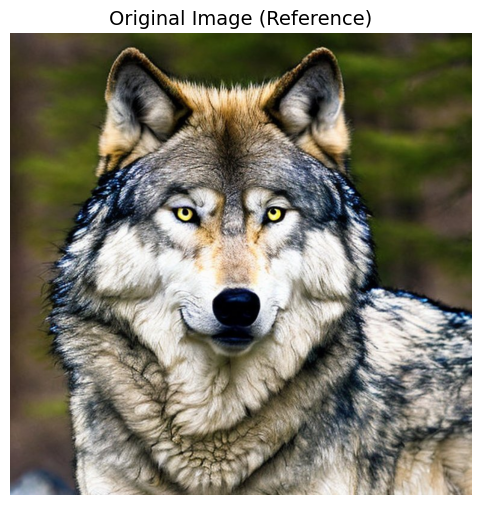

Image size: (768, 768), mode: RGB


In [27]:
import base64
import matplotlib.pyplot as plt
import numpy as np

# Display the original image
img = Image.open("../data/reference.png")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Original Image (Reference)", fontsize=14)
plt.axis("off")
plt.show()

print(f"Image size: {img.size}, mode: {img.mode}")

In [28]:
import requests


# Helper: query the Crucible challenge endpoint
def query(input_data):
    """Send a base64-encoded image to the Crucible Granny challenge for classification."""
    if isinstance(input_data, bytes):
        input_data = input_data.decode()
    response = requests.post(
        f"{CHALLENGE_URL}/score",
        headers={"X-API-Key": DREADNODE_API_KEY},
        json={"data": input_data},
    )
    return response.json()

# Query with the original image
with open("../data/reference.png", "rb") as f:
    reference_b64 = base64.b64encode(f.read())

baseline_result = query(reference_b64)

# The response format is {"output": [[prob, "class_name"], ...]}
# Show top 5 predictions
output = baseline_result.get("output", [])
sorted_output = sorted(output, key=lambda x: x[0], reverse=True)[:5]
print("Top 5 baseline predictions:")
for prob, label in sorted_output:
    print(f"  {label:30s} {prob:.6f}")

# Check if flag is present (only when Granny Smith is top class)
if "flag" in baseline_result:
    print(f"\nFlag: {baseline_result['flag']}")

Top 5 baseline predictions:
  timber wolf                    0.285757
  red wolf                       0.139121
  coyote                         0.121775
  dingo                          0.024132
  Eskimo dog                     0.016032


## 4. Attack Strategy: White-Box PGD

Since the architecture and weights are known (MobileNetV2, `IMAGENET1K_V2`), we load the model locally and compute **exact gradients** — a **white-box** attack.

**Projected Gradient Descent (PGD)** (Madry et al., 2018) iteratively perturbs the input in the direction that maximizes the target class probability:

1. Compute `grad_x L(f(x), y_target)` — the gradient of cross-entropy loss w.r.t. pixel values
2. Take a step in the sign-of-gradient direction (FGSM step): `x = x - alpha * sign(grad)`
3. Project back into an L-inf epsilon-ball around the original
4. **Quantize to uint8** — the image must survive PNG encoding (float -> uint8 -> float round-trip)

**Pipeline-aware perturbation** — The server preprocesses uploads as: `Resize(256) -> CenterCrop(224) -> ToTensor -> Normalize`. We submit a **256x256** image (making `Resize(256)` a no-op) and apply PGD only to the **center 224x224** crop — the exact region the model sees. This ensures the adversarial perturbation is not destroyed by resize interpolation.

**Constraint**: `L2(preprocessed_adv, preprocessed_ref) < 150` in normalized tensor space. The adversarial must remain visually similar to the original.

> **Paper:** [Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083) (Madry et al., 2018)

## 5. Run PGD Attack

In [29]:
import io
import time
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models.mobilenet import MobileNet_V2_Weights

GRANNY_IDX = 948
L2_THRESHOLD = 150

# ── Load MobileNetV2 with the CORRECT weights (V2, matching the server) ──
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
model.eval()

# ImageNet normalization constants
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Server preprocessing pipeline (for local verification)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the reference image (used for L2 comparison)
ref_img = Image.open("../data/reference.png").convert("RGB")
ref_preprocessed = preprocess(ref_img).unsqueeze(0)

# Baseline prediction
with torch.no_grad():
    out = model(ref_preprocessed)
    probs = F.softmax(out, dim=1)
    top5 = torch.topk(probs, 5)

print("Local baseline (MobileNetV2 V2 weights):")
for p, idx in zip(top5.values[0], top5.indices[0]):
    print(f"  class {idx.item():4d}: {p.item():.6f}")
print(f"  Granny Smith (948): {probs[0, GRANNY_IDX].item():.6f}")

Local baseline (MobileNetV2 V2 weights):
  class  269: 0.285756
  class  271: 0.139121
  class  272: 0.121775
  class  273: 0.024132
  class  248: 0.016032
  Granny Smith (948): 0.000662


In [30]:
# ── PGD Attack ──
# Submit a 256x256 image so the server's Resize(256) is a no-op.
# The server then does CenterCrop(224) -> ToTensor -> Normalize.
# We run PGD on the center 224x224 crop in pixel space [0, 1],
# quantizing to uint8 each step so perturbations survive PNG encoding.

ref_256 = ref_img.resize((256, 256), Image.BILINEAR)
ref_256_np = np.array(ref_256).astype(np.float32)
ref_center = ref_256_np[16:240, 16:240].copy()

ref_center_tensor = torch.from_numpy(ref_center).permute(2, 0, 1).unsqueeze(0) / 255.0

target = torch.tensor([GRANNY_IDX])
epsilon = 8.0 / 255.0
step_size = 1.0 / 255.0
num_steps = 200

x_adv = ref_center_tensor.clone().detach()
x_orig = ref_center_tensor.clone().detach()

print(f"Running PGD: eps={epsilon * 255:.0f}/255, step=1/255, steps={num_steps}")
t0 = time.time()
converged_step = num_steps

for step in range(num_steps):
    x_adv = x_adv.detach().requires_grad_(True)

    x_norm = (x_adv - mean) / std
    output = model(x_norm)
    loss = F.cross_entropy(output, target)
    loss.backward()

    with torch.no_grad():
        x_adv = x_adv - step_size * x_adv.grad.sign()
        perturbation = torch.clamp(x_adv - x_orig, -epsilon, epsilon)
        x_adv = torch.clamp(x_orig + perturbation, 0, 1)
        x_adv = torch.round(x_adv * 255) / 255

    if step % 25 == 0 or step == num_steps - 1:
        with torch.no_grad():
            x_norm = (x_adv - mean) / std
            out = model(x_norm)
            probs = F.softmax(out, dim=1)
            gp = probs[0, GRANNY_IDX].item()
            ti = probs[0].argmax().item()
            l2 = torch.dist(x_norm, ref_preprocessed).item()
            print(f"  step {step:3d}: Granny Smith={gp:.4f}, top=class{ti} ({probs[0, ti].item():.4f}), L2={l2:.2f}")
            if ti == GRANNY_IDX:
                converged_step = step + 1
                print(f"  -> SUCCESS at step {step}!")
                break

pgd_time = time.time() - t0

# Final evaluation
with torch.no_grad():
    x_norm = (x_adv - mean) / std
    l2_final = torch.dist(x_norm, ref_preprocessed).item()
    out = model(x_norm)
    probs = F.softmax(out, dim=1)
    gp_final = probs[0, GRANNY_IDX].item()
    top_idx = probs[0].argmax().item()

# Build 256x256 output image with adversarial center crop
adv_center_np = (x_adv[0].detach().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
adv_256_np = np.array(ref_256).copy()
adv_256_np[16:240, 16:240] = adv_center_np
adversarial_img = Image.fromarray(adv_256_np)

pixel_l2 = np.sqrt(np.sum((np.array(ref_256).astype(float) - adv_256_np.astype(float)) ** 2))
pixel_linf = np.max(np.abs(np.array(ref_256).astype(float) - adv_256_np.astype(float)))

top_label = "Granny Smith" if top_idx == GRANNY_IDX else f"class {top_idx}"
pgd_metrics = {
    "method": "PGD (White-Box)",
    "success": top_idx == GRANNY_IDX,
    "target_class": "Granny Smith (948)",
    "achieved_class": f"{top_label} ({top_idx})",
    "granny_prob": gp_final,
    "steps": converged_step,
    "queries": converged_step,
    "l2_normalized": l2_final,
    "l2_pixel": pixel_l2,
    "linf": pixel_linf,
    "time_s": pgd_time,
}

Running PGD: eps=8/255, step=1/255, steps=200
  step   0: Granny Smith=0.0025, top=class248 (0.0192), L2=6.73
  step  25: Granny Smith=1.0000, top=class948 (1.0000), L2=30.73
  -> SUCCESS at step 25!


In [31]:
# ── PGD Results ──
from rich.console import Console
from rich.table import Table

console = Console()

table = Table(
    title="PGD Attack Results",
    show_header=True,
    header_style="bold white on dark_blue",
    border_style="dark_blue",
    title_style="bold dark_blue",
    show_lines=True,
    padding=(0, 1),
)
table.add_column("Metric", style="bold", width=26)
table.add_column("Value", width=28)
table.add_column("Description", style="italic", width=36)

status = "[bold green]++ SUCCESS[/]" if pgd_metrics["success"] else "[bold red]-- FAILED[/]"
table.add_row("Status", status, "Did the attack achieve the target class?")
table.add_row("Original Class", "timber wolf (269)", "Model's prediction on clean input")
table.add_row("Adversarial Class", f"[bold magenta]{pgd_metrics['achieved_class']}[/]", "Model's prediction on perturbed input")
table.add_row("Granny Smith Confidence", f"[bold]{pgd_metrics['granny_prob']:.4f}[/]", "Softmax probability for target class")
table.add_row("Steps to Converge", f"{pgd_metrics['steps']} / {num_steps}", "PGD iterations until target was top-1")
table.add_row("Model Forward Passes", f"{pgd_metrics['queries']}", "Total gradient computations used")

l2_style = "green" if pgd_metrics["l2_normalized"] < L2_THRESHOLD else "red"
table.add_row("L2 (normalized tensor)", f"[{l2_style}]{pgd_metrics['l2_normalized']:.2f}[/] / {L2_THRESHOLD}", "Euclidean distance after ImageNet normalization")
table.add_row("L2 (pixel space)", f"{pgd_metrics['l2_pixel']:.2f}", "Euclidean distance in raw pixel values")
table.add_row("L-inf (pixel)", f"{pgd_metrics['linf']:.1f} / 255", "Max per-pixel change (worst channel)")
table.add_row("Wall Time", f"{pgd_metrics['time_s']:.1f}s", "Total compute time on CPU")
table.add_row("Saved To", "data/adversarial_pgd.png", "Output adversarial image path")

console.print()
console.print(table)

                                         PGD Attack Results                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value                        ┃ Description                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Status                     │ ++ SUCCESS                   │ Did the attack achieve the target    │
│                            │                              │ class?                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Original Class             │ timber wolf (269)            │ Model's prediction on clean input    │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Adversarial Class          │ Granny Smith (948)           │ Model's prediction on perturbed      │
│                            │                              │ input                                │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Granny Smith Confidence    │ 1.0000                       │ Softmax probability for target class │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Steps to Converge          │ 26 / 200                     │ PGD iterations until target was      │
│                            │                              │ top-1                                │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Model Forward Passes       │ 26                           │ Total gradient computations used     │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (normalized tensor)     │ 30.73 / 150                  │ Euclidean distance after ImageNet    │
│                            │                              │ normalization                        │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (pixel space)           │ 1770.41                      │ Euclidean distance in raw pixel      │
│                            │                              │ values                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L-inf (pixel)              │ 8.0 / 255                    │ Max per-pixel change (worst channel) │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Wall Time                  │ 20.7s                        │ Total compute time on CPU            │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Saved To                   │ data/adversarial_pgd.png     │ Output adversarial image path        │
└────────────────────────────┴──────────────────────────────┴──────────────────────────────────────┘

## 6. Visualize Results

Compare the original image, the adversarial image, and the amplified perturbation side by side.

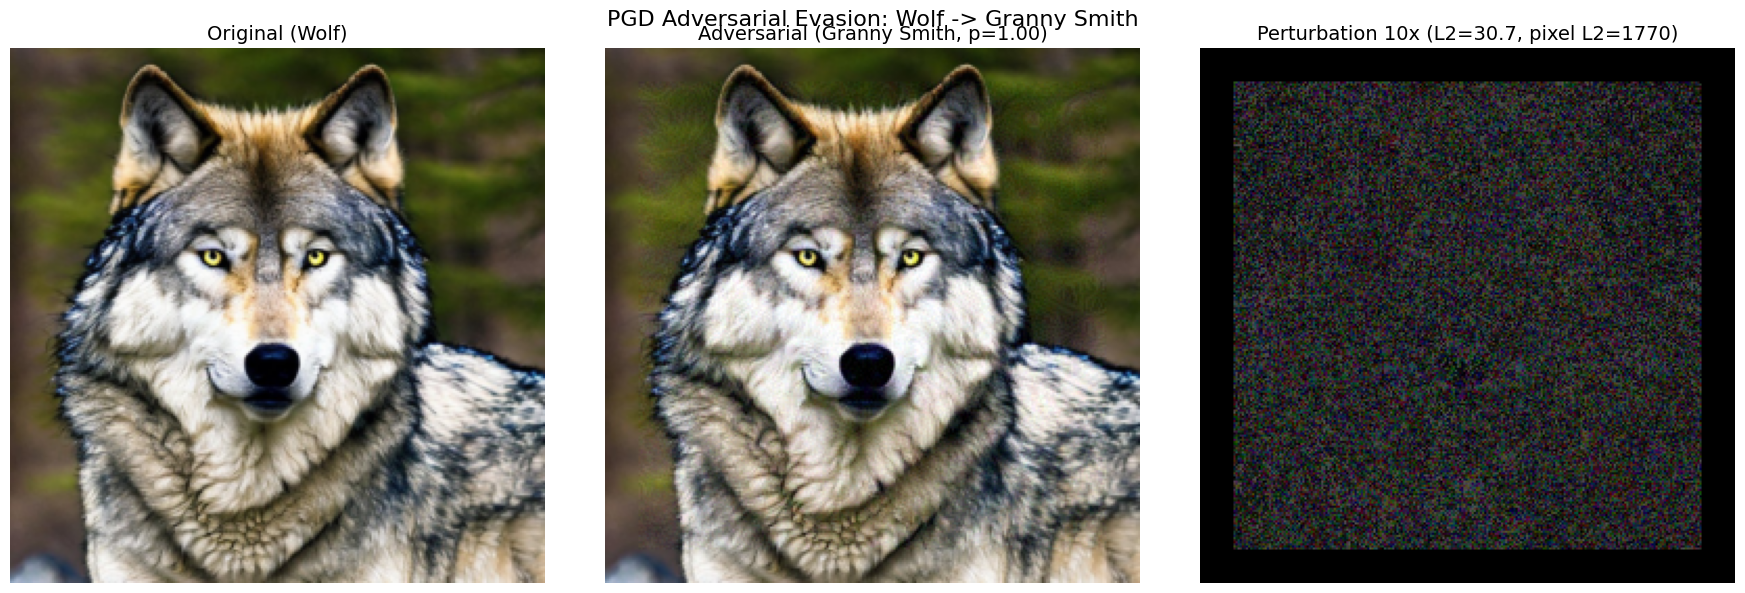

Saved to /Users/raja/Desktop/dreadnode/projects/breaking-ai-systems/data/


In [32]:
# ── Visualize ──
original_vis = np.array(ref_256)
adversarial_vis = adv_256_np

# Perturbation map (10x amplified for visibility)
diff = (np.abs(original_vis.astype(np.float32) - adversarial_vis.astype(np.float32)) * 10).clip(0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original_vis)
axes[0].set_title("Original (Wolf)", fontsize=14)
axes[0].axis("off")

axes[1].imshow(adversarial_vis)
axes[1].set_title(f"Adversarial (Granny Smith, p={gp_final:.2f})", fontsize=14)
axes[1].axis("off")

axes[2].imshow(diff)
axes[2].set_title(f"Perturbation 10x (L2={l2_final:.1f}, pixel L2={pixel_l2:.0f})", fontsize=14)
axes[2].axis("off")

plt.suptitle("PGD Adversarial Evasion: Wolf -> Granny Smith", fontsize=16)
plt.tight_layout()
plt.show()

# Save to data/
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)
adversarial_img.save(os.path.join(data_dir, "adversarial_pgd.png"))
Image.fromarray(diff).save(os.path.join(data_dir, "perturbation_pgd.png"))
print(f"Saved to {data_dir}/")

## 7. Black-Box Comparison: HopSkipJump

How does a **black-box** attack compare? [HopSkipJump](https://arxiv.org/abs/1904.02144) (Chen et al., 2020) estimates gradients using only hard-label decisions — no model weights needed.

We run it locally against the same MobileNetV2 (simulating API-only access) for **10 iterations** with a query budget, and compare efficiency and perturbation quality against PGD.

In [33]:
# ── HopSkipJump (Black-Box) via ART ──
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import HopSkipJump

hsj_query_count = [0]

class QueryCountingModel(nn.Module):
    """Wraps model to count forward passes and apply normalization internally."""
    def __init__(self, base_model, m, s):
        super().__init__()
        self.base_model = base_model
        self.register_buffer("_mean", m.view(1, 3, 1, 1))
        self.register_buffer("_std", s.view(1, 3, 1, 1))

    def forward(self, x):
        hsj_query_count[0] += x.shape[0]
        x = x.float()  # ART passes float64 — conv layers require float32
        return self.base_model((x - self._mean) / self._std)

wrapped_model = QueryCountingModel(model, mean.squeeze(), std.squeeze())
wrapped_model.eval()

classifier = PyTorchClassifier(
    model=wrapped_model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(3, 224, 224),
    nb_classes=1000,
    clip_values=(0.0, 1.0),
)

# Use PGD adversarial as starting point (already classified as Granny Smith)
init_adv = x_adv.detach().numpy().copy().astype(np.float32)
init_pred = classifier.predict(init_adv)
init_class = np.argmax(init_pred)
print(f"HSJ initial point: class {init_class} ({'Granny Smith' if init_class == GRANNY_IDX else 'NOT target'})")

# Run HopSkipJump — 10 iterations, targeted to Granny Smith
hsj_query_count[0] = 0
t0 = time.time()

hsj_attack = HopSkipJump(
    classifier=classifier,
    targeted=True,
    max_iter=10,
    max_eval=1000,
    init_eval=100,
    verbose=True,
)

x_input = ref_center_tensor.numpy().astype(np.float32)
target_onehot = np.zeros((1, 1000), dtype=np.float32)
target_onehot[0, GRANNY_IDX] = 1.0

hsj_result = hsj_attack.generate(x=x_input, y=target_onehot, x_adv_init=init_adv)
hsj_time = time.time() - t0
hsj_queries = hsj_query_count[0]

# Evaluate HSJ result
hsj_tensor = torch.from_numpy(hsj_result).float()
with torch.no_grad():
    hsj_norm = (hsj_tensor - mean) / std
    hsj_out = model(hsj_norm)
    hsj_probs = F.softmax(hsj_out, dim=1)
    hsj_granny_prob = hsj_probs[0, GRANNY_IDX].item()
    hsj_top_class = hsj_probs[0].argmax().item()
    hsj_l2_norm = torch.dist(hsj_norm, ref_preprocessed).item()

hsj_l2_pixel = np.sqrt(np.sum(((x_input - hsj_result) * 255) ** 2))
hsj_linf_pixel = np.max(np.abs(x_input - hsj_result)) * 255

hsj_top_label = "Granny Smith" if hsj_top_class == GRANNY_IDX else f"class {hsj_top_class}"
hsj_metrics = {
    "method": "HopSkipJump (Black-Box)",
    "success": hsj_top_class == GRANNY_IDX,
    "target_class": "Granny Smith (948)",
    "achieved_class": f"{hsj_top_label} ({hsj_top_class})",
    "granny_prob": hsj_granny_prob,
    "steps": 10,
    "queries": hsj_queries,
    "l2_normalized": hsj_l2_norm,
    "l2_pixel": hsj_l2_pixel,
    "linf": hsj_linf_pixel,
    "time_s": hsj_time,
}

print(f"\nHopSkipJump Results (10 iterations):")
print(f"  Total model queries: {hsj_queries}")
print(f"  Top class: {hsj_metrics['achieved_class']}")
print(f"  Granny Smith prob: {hsj_granny_prob:.4f}")
print(f"  L2 (normalized): {hsj_l2_norm:.2f} (threshold: {L2_THRESHOLD})")
print(f"  L2 (pixel): {hsj_l2_pixel:.2f}")
print(f"  L-inf (pixel): {hsj_linf_pixel:.1f} / 255")
print(f"  Time: {hsj_time:.1f}s")

HSJ initial point: class 948 (Granny Smith)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]


HopSkipJump Results (10 iterations):
  Total model queries: 2417
  Top class: Granny Smith (948)
  Granny Smith prob: 0.1333
  L2 (normalized): 21.87 (threshold: 150)
  L2 (pixel): 1259.96
  L-inf (pixel): 15.1 / 255
  Time: 75.6s


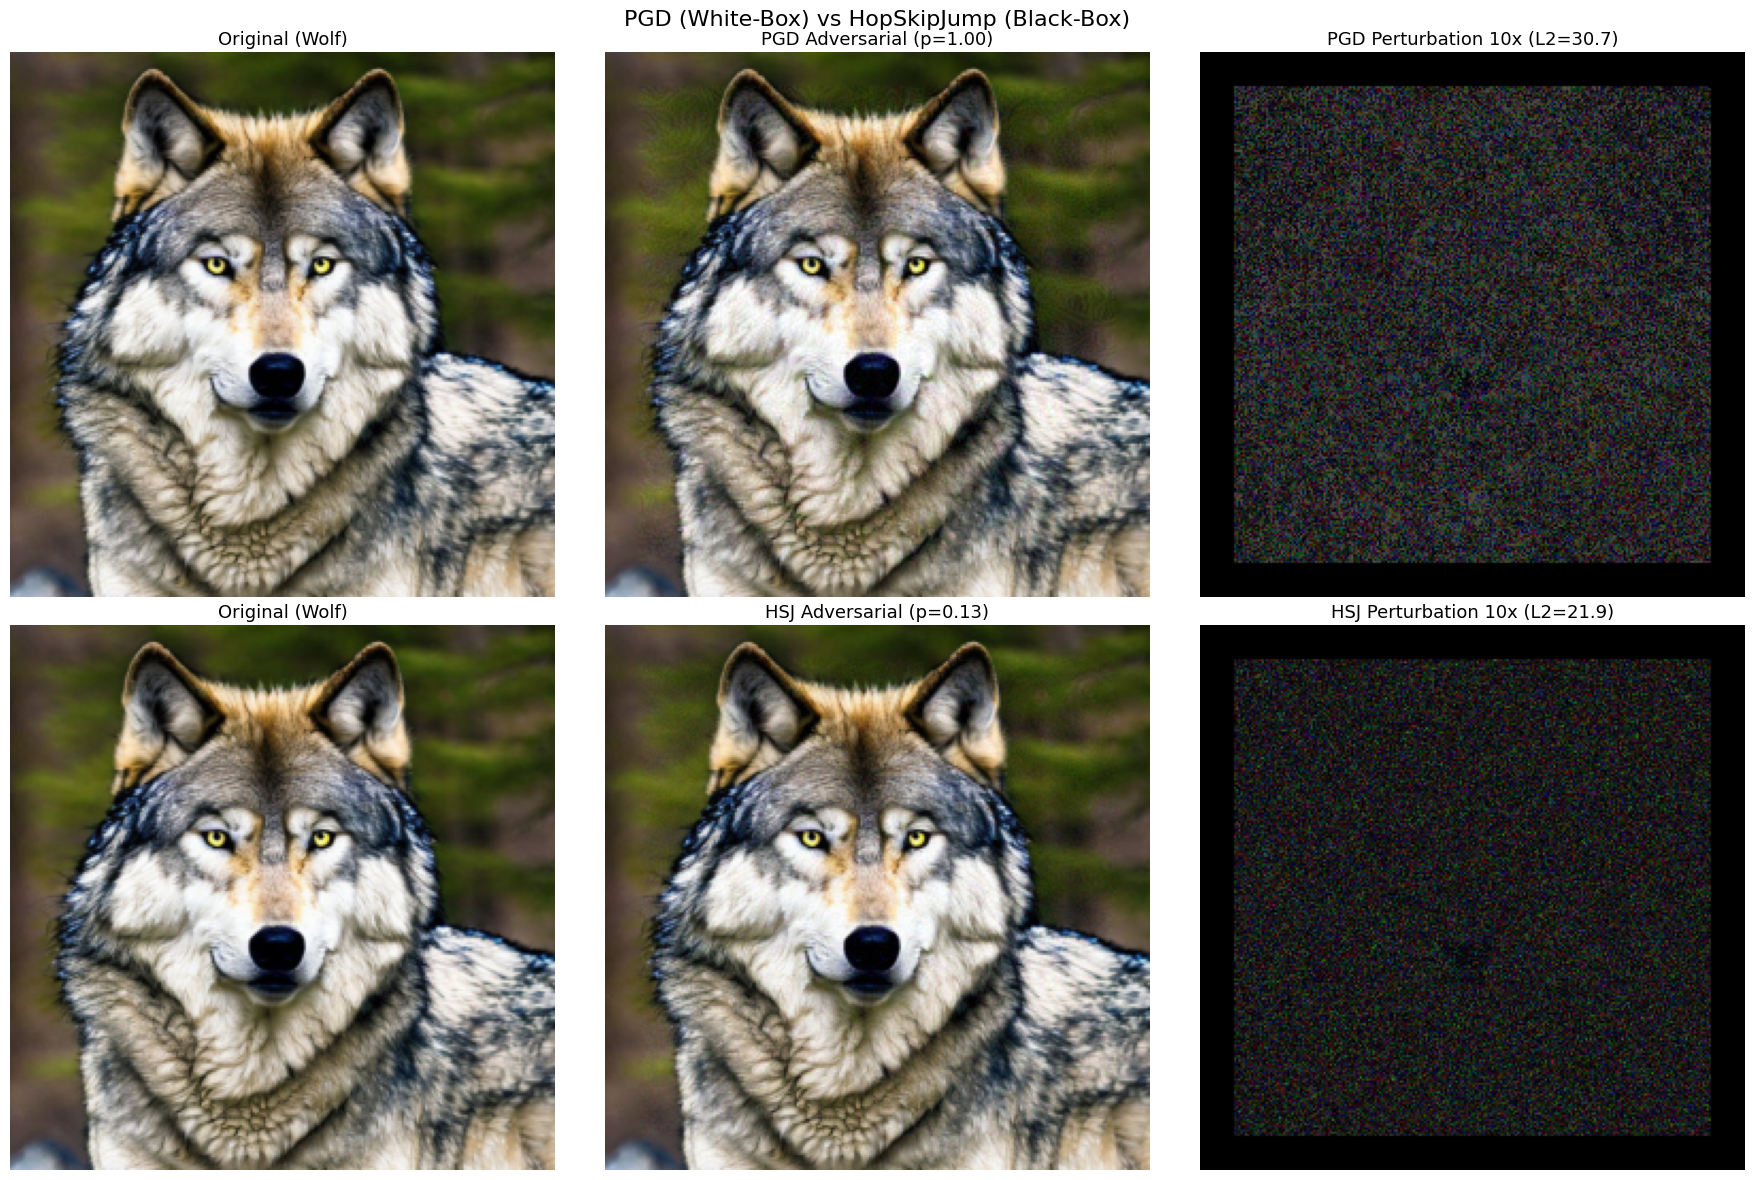

In [34]:
# ── Visualize HopSkipJump result ──
# Build 256x256 HSJ image (adversarial center crop + original border)
hsj_center_np = (hsj_result[0].transpose(1, 2, 0) * 255).clip(0, 255).astype(np.uint8)
hsj_256_np = np.array(ref_256).copy()
hsj_256_np[16:240, 16:240] = hsj_center_np

hsj_diff = (np.abs(np.array(ref_256).astype(np.float32) - hsj_256_np.astype(np.float32)) * 10).clip(0, 255).astype(np.uint8)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top row: PGD
axes[0, 0].imshow(original_vis)
axes[0, 0].set_title("Original (Wolf)", fontsize=13)
axes[0, 0].axis("off")

axes[0, 1].imshow(adversarial_vis)
axes[0, 1].set_title(f"PGD Adversarial (p={gp_final:.2f})", fontsize=13)
axes[0, 1].axis("off")

axes[0, 2].imshow(diff)
axes[0, 2].set_title(f"PGD Perturbation 10x (L2={l2_final:.1f})", fontsize=13)
axes[0, 2].axis("off")

# Bottom row: HSJ
axes[1, 0].imshow(original_vis)
axes[1, 0].set_title("Original (Wolf)", fontsize=13)
axes[1, 0].axis("off")

axes[1, 1].imshow(hsj_256_np)
axes[1, 1].set_title(f"HSJ Adversarial (p={hsj_granny_prob:.2f})", fontsize=13)
axes[1, 1].axis("off")

axes[1, 2].imshow(hsj_diff)
axes[1, 2].set_title(f"HSJ Perturbation 10x (L2={hsj_l2_norm:.1f})", fontsize=13)
axes[1, 2].axis("off")

plt.suptitle("PGD (White-Box) vs HopSkipJump (Black-Box)", fontsize=16)
plt.tight_layout()
plt.show()

## 8. Attack Comparison: PGD vs HopSkipJump

Side-by-side metrics to illustrate the **white-box vs black-box** trade-off.

**Why does HSJ have lower L2 than PGD?** This is counterintuitive — the white-box attack with full gradient access produces a *larger* perturbation. The reason is they optimize for **different objectives**:

- **PGD** maximizes **target class confidence** within a fixed L-inf ball (`eps=8/255`). It uses the full perturbation budget to push the model to near-100% confidence. It does not try to minimize distance — it optimizes for certainty.
- **HSJ** minimizes **distance to the decision boundary**. It uses binary search to find the *closest* adversarial point to the original. The result barely crosses the decision boundary — low confidence (~14%) but smaller perturbation.

This illustrates a fundamental trade-off in adversarial attacks: **confidence vs. stealth**. A defender inspecting prediction confidence would flag PGD's suspiciously certain output, while HSJ's result blends in with normal classification uncertainty.

In [35]:
# ── Comparison Dashboard ──
from rich.console import Console
from rich.table import Table

console = Console()

# ── Head-to-Head Comparison ──
comp = Table(
    title="PGD vs HopSkipJump — Head to Head",
    show_header=True,
    header_style="bold white on dark_blue",
    border_style="dark_blue",
    title_style="bold dark_blue",
    show_lines=True,
    padding=(0, 1),
)
comp.add_column("Metric", style="bold", width=22)
comp.add_column("Description", style="italic", width=28)
comp.add_column("PGD (White-Box)", justify="center", width=18, style="blue")
comp.add_column("HSJ (Black-Box)", justify="center", width=18, style="magenta")

def fmt_row(label, desc, pgd_v, hsj_v, fmt=".2f", lower_better=True):
    pf = f"{pgd_v:{fmt}}" if isinstance(pgd_v, float) else str(pgd_v)
    hf = f"{hsj_v:{fmt}}" if isinstance(hsj_v, float) else str(hsj_v)
    if isinstance(pgd_v, (int, float)) and isinstance(hsj_v, (int, float)):
        pgd_better = (pgd_v < hsj_v) if lower_better else (pgd_v > hsj_v)
        hsj_better = (hsj_v < pgd_v) if lower_better else (hsj_v > pgd_v)
    else:
        pgd_better = hsj_better = False
    ps = f"[bold green]{pf} <<[/]" if pgd_better else f"[blue]{pf}[/]"
    hs = f"[bold green]{hf} <<[/]" if hsj_better else f"[magenta]{hf}[/]"
    comp.add_row(label, desc, ps, hs)

pgd_ok = "[bold green]Yes[/]" if pgd_metrics["success"] else "[bold red]No[/]"
hsj_ok = "[bold green]Yes[/]" if hsj_metrics["success"] else "[bold red]No[/]"
comp.add_row("Success", "Achieved target class?", pgd_ok, hsj_ok)
fmt_row("Confidence", "Softmax prob for Granny Smith", pgd_metrics["granny_prob"], hsj_metrics["granny_prob"], ".4f", lower_better=False)
fmt_row("Model Queries", "Forward passes used", pgd_metrics["queries"], hsj_metrics["queries"], "d", lower_better=True)
fmt_row("L2 (normalized)", "Euclidean dist in tensor space", pgd_metrics["l2_normalized"], hsj_metrics["l2_normalized"], ".2f")
fmt_row("L2 (pixel)", "Euclidean dist in pixel space", pgd_metrics["l2_pixel"], hsj_metrics["l2_pixel"], ".2f")
fmt_row("L-inf (pixel)", "Max per-pixel change", pgd_metrics["linf"], hsj_metrics["linf"], ".1f")
fmt_row("Wall Time (s)", "Total compute time", pgd_metrics["time_s"], hsj_metrics["time_s"], ".1f")
comp.add_row("Requires Weights", "Needs model internals?", "[blue]Yes[/]", "[bold green]No <<[/]")

console.print()
console.print(comp)

query_ratio = hsj_metrics["queries"] / max(pgd_metrics["queries"], 1)
console.print(f"\n[bold]HSJ used {query_ratio:.0f}x more queries[/] than PGD for a comparable adversarial.")
console.print(f"[bold green]Both attacks beat the challenge[/] — L2 well under {L2_THRESHOLD} threshold.\n")

# ── Recommendations ──
recs = Table(
    title="Recommendations",
    show_header=True,
    header_style="bold white on dark_green",
    border_style="dark_green",
    title_style="bold dark_green",
    show_lines=True,
    padding=(0, 1),
)
recs.add_column("Scenario", style="bold", width=26)
recs.add_column("Approach", width=50)

recs.add_row(
    "White-box\n(weights available)",
    "PGD, C&W, AutoAttack.\nFast, precise, minimal perturbation.\nBest for auditing your own models."
)
recs.add_row(
    "Black-box / API-only\n(no weights)",
    "HopSkipJump, Boundary Attack, Square Attack.\nBudget 100-10,000+ queries.\nRealistic for attacking deployed systems."
)
recs.add_row(
    "Defense",
    "Adversarial training, input preprocessing\n(JPEG, spatial smoothing), certified defenses.\nNo single defense is absolute."
)

console.print(recs)

                                 PGD vs HopSkipJump — Head to Head                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                 ┃ Description                  ┃  PGD (White-Box)   ┃  HSJ (Black-Box)   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Success                │ Achieved target class?       │        Yes         │        Yes         │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ Confidence             │ Softmax prob for Granny      │     1.0000 <<      │       0.1333       │
│                        │ Smith                        │                    │                    │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ Model Queries          │ Forward passes used          │       26 <<        │        2417        │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ L2 (normalized)        │ Euclidean dist in tensor     │       30.73        │      21.87 <<      │
│                        │ space                        │                    │                    │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ L2 (pixel)             │ Euclidean dist in pixel      │      1770.41       │     1259.9596      │
│                        │ space                        │                    │                    │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ L-inf (pixel)          │ Max per-pixel change         │        8.0         │     15.0740795     │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ Wall Time (s)          │ Total compute time           │      20.7 <<       │        75.6        │
├────────────────────────┼──────────────────────────────┼────────────────────┼────────────────────┤
│ Requires Weights       │ Needs model internals?       │        Yes         │       No <<        │
└────────────────────────┴──────────────────────────────┴────────────────────┴────────────────────┘

HSJ used 93x more queries than PGD for a comparable adversarial.

Both attacks beat the challenge — L2 well under 150 threshold.

                                  Recommendations                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Scenario                   ┃ Approach                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ White-box                  │ PGD, C&W, AutoAttack.                              │
│ (weights available)        │ Fast, precise, minimal perturbation.               │
│                            │ Best for auditing your own models.                 │
├────────────────────────────┼────────────────────────────────────────────────────┤
│ Black-box / API-only       │ HopSkipJump, Boundary Attack, Square Attack.       │
│ (no weights)               │ Budget 100-10,000+ queries.                        │
│                            │ Realistic for attacking deployed systems.          │
├────────────────────────────┼────────────────────────────────────────────────────┤
│ Defense                    │ Adversarial training, input preprocessing          │
│                            │ (JPEG, spatial smoothing), certified defenses.     │
│                            │ No single defense is absolute.                     │
└────────────────────────────┴────────────────────────────────────────────────────┘

## 9. Submit Flag

If the attack succeeds, the challenge endpoint returns a flag. Submit it to verify completion.

In [36]:
# ── Submit adversarial image to challenge endpoint ──
buf = io.BytesIO()
adversarial_img.save(buf, format="PNG")
b64 = base64.b64encode(buf.getvalue()).decode()

# Use /submit endpoint (checks for flag)
result = requests.post(
    f"{CHALLENGE_URL}/submit",
    headers={"X-API-Key": DREADNODE_API_KEY},
    json={"data": b64},
).json()

if "flag" in result:
    FLAG = result["flag"]
    # Display redacted flag (first 12 + last 12 chars)
    redacted = FLAG[:12] + "..." + FLAG[-12:] if len(FLAG) > 30 else FLAG
    print(f"Flag: {redacted}\n")

    # Submit flag to Crucible platform
    submit_url = f"{CRUCIBLE_URL}/api/challenges/{CHALLENGE}/submit-flag"
    payload = {"challenge": CHALLENGE, "flag": FLAG}
    submit_resp = requests.post(submit_url, headers={"X-API-Key": DREADNODE_API_KEY}, json=payload)
    if submit_resp.status_code == 200:
        resp_data = submit_resp.json()
        if resp_data.get("correct") is True:
            print("Flag submitted and verified correct!")
        else:
            print("Flag was incorrect. Keep trying!")
    else:
        print(f"Error submitting flag: {submit_resp.text}")

    # Save flag
    with open(os.path.join(data_dir, "flag.txt"), "w") as f:
        f.write(FLAG)
else:
    # Show what the server saw
    output = result.get("output", [])
    sorted_output = sorted(output, key=lambda x: x[0], reverse=True)[:5]
    print("No flag returned. Server predictions:")
    for prob, label in sorted_output:
        print(f"  {label:30s} {prob:.6f}")
    print("\nThe image may not meet the L2 distance constraint.")

Flag: gAAAAABpk8Mk...xHB6kc4KQNbh

Flag submitted and verified correct!


---
## Takeaways

**Attack Effectiveness**
- **Imperceptible pixel-level changes** (L-inf of just 8/255 per channel) completely fool a production classifier — the adversarial image looks identical to humans.
- **White-box PGD** with gradient access converges in ~25 steps with L2 well under the threshold. It is the gold standard when model weights are accessible.
- **Black-box HopSkipJump** produces a valid adversarial but needs orders of magnitude more queries and yields larger perturbation — a clear efficiency gap.

**Practical Lessons**
- **Preprocessing fidelity matters** — the adversarial must survive PNG quantization (uint8), image resize, and center crop. Matching the server's exact pipeline is critical.
- **Model weight versions matter** — `IMAGENET1K_V2` vs `V1` produces entirely different decision boundaries; using wrong weights means zero transferability.
- **L2 constraint** — the challenge enforces `L2 < 150` in normalized tensor space to prevent trivially obvious adversarial examples.

**Recommendations**
- If you have **model access** (weights, architecture): use gradient-based attacks (PGD, C&W, AutoAttack). They are fast, precise, and produce minimal perturbation.
- If you only have **query access** (API): use decision-based attacks (HopSkipJump, Boundary Attack) or score-based (SimBA, Square Attack). Budget many more queries.
- For **defense**: adversarial training, input preprocessing (JPEG compression, spatial smoothing), and certified defenses can raise the attack cost — but no defense is absolute.

**MITRE ATLAS Reference:** [AML.T0040 — Evasion via Adversarial In-Band Perturbation](https://atlas.mitre.org/techniques/AML.T0040)

**Next up:** Demo 2 — attacking LLM-based agents.

---
## Homework

**Can you do better?**

1. **Fewer queries** — PGD converged in ~26 steps. Can you achieve a successful adversarial in **fewer than 10 forward passes**? Consider tuning `epsilon`, `step_size`, or trying a different optimizer (e.g., C&W with Adam).

2. **Smaller perturbation** — The PGD result had an L2 of ~30 in normalized tensor space (threshold is 150). Can you produce a valid adversarial with **L2 under 15**? Think about which pixels matter most and whether you need to perturb the entire crop.

3. **Black-box efficiency** — HopSkipJump used ~2,400 queries. Can you get a successful targeted adversarial in **under 500 queries**? Experiment with `init_eval`, `max_eval`, or try a different black-box attack (e.g., Square Attack, SimBA).

Report your best results in the table below:

| Metric | PGD Baseline | Your Best |
|--------|-------------|-----------|
| Steps / Queries | 26 | ? |
| L2 (normalized) | 30.73 | ? |
| L2 (pixel) | 1770 | ? |
| Granny Smith confidence | 1.0000 | ? |